import modules

In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from shapely.geometry import Point
import requests
from zipfile import ZipFile
import os
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

Get Weather Stations details available from Met Eireann :'https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv
And read into dataframe : wsdf, there are 2083 stations

In [21]:
wsdf = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv')
wsdf.head
wsdf.dtypes
print(set(wsdf['open year']))

{'1993', '1841', '1931', '2002', '1915', '1873', '1913', '2001', '1889', '1864', '1976', '1894', '1874', '1916', '1994', '1871', '1884', '1956', '1885', '2022', '1959', '2014', '1960', '1978', '1980', '2007', '1919', '2006', '1879', '1911', '1999', '1918', '1925', '1944', '1898', '1870', '1924', '1923', '1938', '(null)', '1862', '1961', '2016', '1981', '2012', '1943', '1951', '1902', '1995', '1955', '1966', '1905', '1953', '1970', '1936', '1958', '1929', '1965', '1895', '1996', '2010', '1941', '1934', '1876', '2020', '1878', '1886', '1914', '1987', '1998', '1983', '1940', '1975', '1937', '2015', '1926', '1974', '2004', '1910', '1935', '1883', '1920', '1982', '1952', '1928', '1945', '2008', '1997', '1930', '2019', '1949', '1908', '2009', '1948', '1950', '1946', '1986', '2021', '1890', '1892', '2000', '1968', '1967', '1985', '1984', '1972', '2017', '2011', '1903', '1896', '1897', '1893', '1904', '1901', '1947', '1917', '1964', '1875', '1977', '1866', '2005', '1969', '2013', '1971', '1990

The Values in 'open year' and 'close year' which describe the time range of recording for each staion are a combination of numeric text values and '(null)'
We want to analyse data from Weather Stations which have data from 2010 to the present
We'll convert the '(null)' to a future year '3000' and convert to int.
This allows us to filter the data based on Year and reduces the number of stations to 429

In [25]:
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].replace(['(null)'], '3000')
#Change 'open year' and 'close year' to int
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].astype(int)
#Filter Weather Stations to those reporting data from 2013 to the present
wsdf=wsdf.loc[(wsdf['close year'] == 3000) & (wsdf['open year'] < 2014)]
wsdf.head

<bound method NDFrame.head of        county  station name                             name  height(m)  \
0      Antrim          5880                  LH_RATHLIN_WEST         10   
1      Carlow          4415              TULLOW (Waterworks)         76   
10     Carlow          6114             POLLMOUNTY FISH FARM         24   
15     Carlow           375                         OAK PARK         62   
17     Carlow          4515           TULLOW (Ardoyne Glebe)         79   
...       ...           ...                              ...        ...   
2074  Wicklow          9420  M.GLENMALURE (Cloghernagh For.)        436   
2075  Wicklow          9520   M.RATHDRUM (Ballintombay For.)        384   
2078  Wicklow          9820                    M.LOUGH OULER        457   
2079  Wicklow          2415            GLEN IMAAL (For.Stn.)        213   
2080  Wicklow          2420              OLDBRIDGE (Oakview)        335   

      easting  northing  latitude  longitude  open year  close year  

Get a visual idea of the distribution of the stations by superimposing a plot of the stations on a map of Ireland(state) using this shape file from here https://www.geoboundaries.org/data/1_3_3/zip/shapefile/IRL/IRL_ADM1.shp.zip

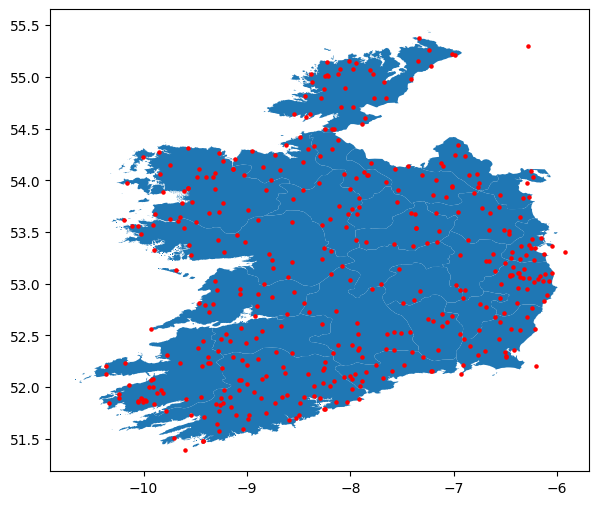

In [26]:
def stationinirelandplot(df):
    IRL_map= gpd.read_file('./IRL_adm/IRL_adm1.shp')
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = GeoDataFrame(wsdf, geometry=geometry) 
    gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);
stationinirelandplot(wsdf)

Remove Rathlin Island Station from dataframe as it is not in the state

In [27]:
wsdf = wsdf.loc[wsdf["name"] != 'LH_RATHLIN_WEST']
wsdf.shape

(417, 11)

For each of the stations, check if hourly data exists, if not drop it from the stations dataset, otherwise download the files to the zipped folder and unzip to the unzipped folder.
The files are named using the station name which is a number. For example the station name of ROCHES POINT is 1075 and the file to download is hly1075.zip. There are 25 staions remaining after this

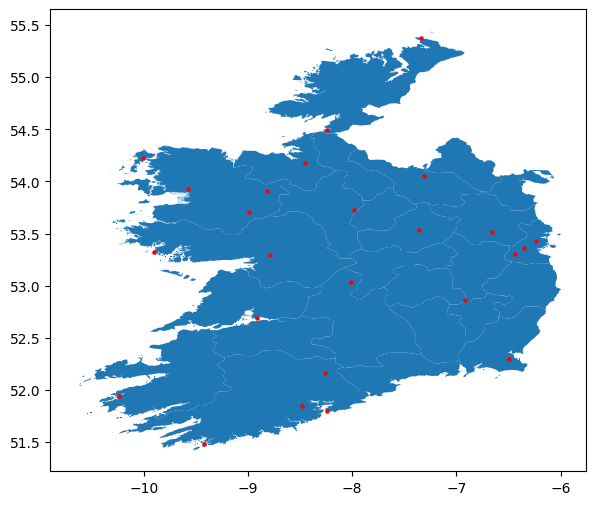

In [28]:
def validurl(url):
	try:
		get = requests.get(url)		 
		if get.status_code == 200:
			return True
		else:
			return False
	except requests.exceptions.RequestException as e:
		return False

baseurl='https://cli.fusio.net/cli/climate_data/webdata/hly'
basezipfile='./weatherstationdata/zipped/hly'
baseunzipfile=basezipfile.replace("zipped", "unzipped")
for station in wsdf['station name']:
    stationurl=baseurl+str(station)+'.zip'
    stationzipfile=basezipfile+str(station)+'.zip'
    stationzipfolder=stationzipfile[:-4]
    stationunzipfolder=stationzipfolder.replace("zipped", "unzipped")
    if validurl(stationurl):
	    pass
        response = requests.get(stationurl)
        open(stationzipfile, "wb").write(response.content)
        with ZipFile(stationzipfile, 'r') as zip_ref:
                zip_ref.extractall(stationunzipfolder)
    else:
        wsdf = wsdf.loc[wsdf["station name"] != station]
stationinirelandplot(wsdf)

Get a distribution for the remaining stations. By finding the station's nearest neighbour and the distance between them using Balltree and Haversine method.
Distribution looks reasonably Ok, the distances are not significant
## Make this graph better ##

<Axes: ylabel='Density'>

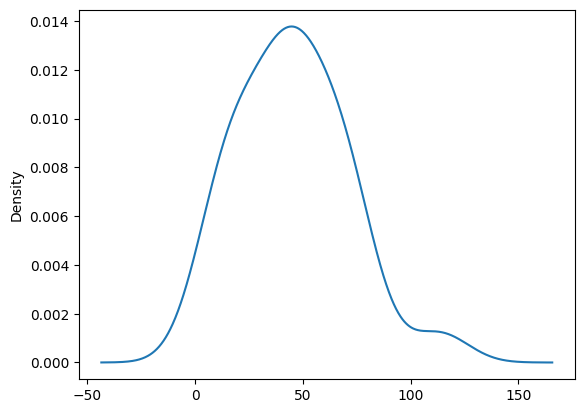

In [30]:
# convert the degrees to radians and store in the dataframe
wsdf[["latradian", "longradian"]] = np.deg2rad(wsdf[["latitude", "longitude"]])
ball_tree = BallTree(wsdf[["latradian", "longradian"]], metric="haversine")
distances,neighbours = ball_tree.query(
    wsdf[["latradian", "longradian"]],
    k=2,
    return_distance=True,
    sort_results=True,
)
#remove the nearwst neighbour and distance which is itself and 0
neighbours = neighbours[:, 1:]
distances = distances[:, 1:]

wsdf["nearest_stations_names"] = [
    wsdf["name"].iloc[n].to_list() for n in neighbours
]
wsdf["nearest_stations_station_names"] = [
    wsdf["station name"].iloc[n].to_list() for n in neighbours
]
wsdf["nearest_station_distance(rad)"] = distances
#convert distances to km
wsdf["nearest_station_distance(km)"] = distances*6371
wsdf['nearest_station_name'] = wsdf["nearest_stations_names"].str[0]
wsdf['nearest_station_station_name'] = wsdf["nearest_stations_station_names"].str[0].astype(int)
wsdf.drop(['nearest_stations_names', 'nearest_stations_station_names'], axis=1)
wsdf.to_csv('./weatherstationdata/stationinfo.csv')
#plot the distribution - Make this fancier
wsdf["nearest_station_distance(km)"].plot(kind='kde')

For each file in ./weatherstationdata/unzipped with the pattern hly*.csv - Use regex here
Find  'date:' and for each line until blank line create a dictionary for renaming the columns later
Find column headers starting with date, and check if there is a header called wdsp whic is Wind Speed, 
If there is then write the rest of the file into the processed folder
Rename the columns as per the dictionary
Delete unused columns
23 stations remain that have Windspeed data

In [31]:
wsdf.head

<bound method NDFrame.head of          county  station name                  name  height(m)  easting  \
15       Carlow           375              OAK PARK         62   273000   
43        Cavan           675            BALLYHAISE         78   245200   
136       Clare           518       SHANNON AIRPORT         15   137900   
224        Cork           775         SherkinIsland         21   100781   
245        Cork          3904          CORK AIRPORT        155   166500   
353        Cork          1075          ROCHES POINT         40   182779   
367        Cork           575            MOORE PARK         46   181900   
478     Donegal          1575            MALIN HEAD         20   241939   
536     Donegal          2075                FINNER         33   184300   
600      Dublin          3723              CASEMENT         91   304100   
612      Dublin           175          PHOENIX PARK         48   309915   
624      Dublin           532        DUBLIN AIRPORT         71   31690

In [52]:
import os
wdict={}
stationunziphomefolder = basezipfile[:-4].replace('zipped','unzipped')
for folder in os.listdir(stationunziphomefolder):
    weatherdatafile=stationunziphomefolder+'/'+folder+"/"+folder+'.csv'
    inblock=False
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
            if 'date:' in line or (inblock and line.strip()):
                inblock=True
                wdict[line.split(":")[0]] = line.split("-")[1].strip()
            else:
                if inblock:
                    break
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
                if 'date,' in line:
                    firstline = lineno
                    break 
    if (',wdsp' in line): 
        with open(weatherdatafile, 'r') as wf:
            for lineno, line in enumerate(wf):    
                lines=wf.readlines()   
        # Write file
        stationprochomefolder=stationunziphomefolder.replace('unzipped','processed')
        weatherdataprocfile=stationprochomefolder+"/"+weatherdatafile.split("/")[-1]
        with open(weatherdataprocfile, 'w') as wwf:
            # iterate each line
            for lineno, line in enumerate(lines):
                if lineno > (firstline-2):
                    wwf.write(line)
    else:
        print("Not Processing : "+folder)
        stationname=int(folder[3:])
        wsdf = wsdf.loc[wsdf["station name"] != stationname]
wsdf.shape

Not Processing : hly1275
Not Processing : hly175


(23, 19)

In [33]:
wsdf.to_csv('./weatherstationdata/stationinfo_filtered.csv')

Read in the processed Weather Data file.
Combine the Weather Data into allwddf dataframe
For each file read into a dataframe 
Add the station name as a column

In [133]:
allwddf=pd. DataFrame()
for file in os.listdir(stationprochomefolder):
    weatherdataprocfile=stationprochomefolder+"/"+file
    wddf = pd.read_csv(weatherdataprocfile)
    wddf['station name'] = int(file[3:][:-4])
    allwddf=pd.concat([allwddf, wddf], axis=0,ignore_index=True)
    #break
allwddf.head


C:\Users\czl\AppData\Local\Temp\ipykernel_22152\3810692618.py:4: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_22152\3810692618.py:4: DtypeWarning: Columns (2,4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_22152\3810692618.py:4: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_22152\3810692618.py:4: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_22152\3810692618.py:4: DtypeWarning: Columns (2,6,7,8,9,12,14,15,16,

<bound method NDFrame.head of                       date  ind rain  ind.1  temp  ind.2  wetb dewpt vappr  \
0        01-dec-1955 01:00    0  0.0      0  10.7      0  10.0   9.4  11.8   
1        01-dec-1955 02:00    0  2.9      0   9.8      0   9.7  10.0  12.0   
2        01-dec-1955 03:00    0  3.8      0   9.7      0   9.5   9.4  11.7   
3        01-dec-1955 04:00    0  0.8      0   9.8      0   9.7   9.4  11.9   
4        01-dec-1955 05:00    0  0.3      0   8.9      0   8.7   8.3  11.1   
...                    ...  ...  ...    ...   ...    ...   ...   ...   ...   
8131541  31-jan-2023 20:00    0  0.0      0   5.6      0   4.5   2.9   7.5   
8131542  31-jan-2023 21:00    0  0.0      0   5.7      0   4.6   3.0   7.6   
8131543  31-jan-2023 22:00    0  0.0      0   5.7      0   4.4   2.7   7.4   
8131544  31-jan-2023 23:00    0  0.0      0   5.8      0   4.4   2.3   7.2   
8131545  01-feb-2023 00:00    0  0.0      0   5.2      0   4.2   2.8   7.5   

        rhum  ... wdsp  ind.4 wdd

Clean the data 
As we are only interested in the datetime,Windspeed and station name, so remove all other columns
We are only interested in records from 2013 to 2022 inclusive, so remove any outside that range


In [134]:
columns = list(allwddf.columns.values)
retaincolumns=["date","wdsp","station name"]
allwddf = allwddf.loc[:, retaincolumns]
allwddf.head

<bound method NDFrame.head of                       date wdsp  station name
0        01-dec-1955 01:00   16          1075
1        01-dec-1955 02:00   11          1075
2        01-dec-1955 03:00    9          1075
3        01-dec-1955 04:00    5          1075
4        01-dec-1955 05:00   12          1075
...                    ...  ...           ...
8131541  31-jan-2023 20:00    7           875
8131542  31-jan-2023 21:00    8           875
8131543  31-jan-2023 22:00    7           875
8131544  31-jan-2023 23:00    7           875
8131545  01-feb-2023 00:00    5           875

[8131546 rows x 3 columns]>

We are only interested in records from 2013 to 2022 inclusive, so remove any outside that range
Convert date to datetime and use the range to remove the records
This reduces the number of records from 8131546 to 2015904

In [135]:
startdate=pd.to_datetime('2013-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
allwddf['Datetime'] = pd.to_datetime(allwddf['date'], format='%d-%b-%Y %H:%M')
mask = (allwddf['Datetime']  >= startdate) & (allwddf['Datetime'] < enddate)
allwddf = allwddf.loc[mask]
print(allwddf.shape)
allwddf.drop_duplicates(subset=['Datetime', 'station name'],inplace = True)
print(allwddf.shape)

(2015904, 4)
(2015904, 4)


C:\Users\czl\AppData\Local\Temp\ipykernel_22152\205224277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allwddf.drop_duplicates(subset=['Datetime', 'station name'],inplace = True)


Try to convert allwddf.wdsp to int
Get ValueError: invalid literal for int() with base 10: ' '


In [136]:
allwddf.wdsp=allwddf.wdsp.astype(int)


ValueError: invalid literal for int() with base 10: ' '

Look at unique values
As per the error message there are 1 or more values = ' '

In [138]:
print(set(allwddf.wdsp))
#print(allwddf[allwddf.isna().any(axis=1)])

{0, 1, 2, 3, 4, 5, 6, 7, 8, '3', 9, 10, 11, 13, 14, 15, '18', 16, 18, 19, 20, 21, 22, 23, 17, 25, 26, 27, 24, '10', 28, 29, '21', 33, 31, 34, 36, 30, 35, 37, 38, 32, 39, 43, 40, 42, 41, 44, 47, 49, 45, 51, 46, 48, 50, 55, 56, 54, 52, 12, '53', '50', '34', '32', '11', '37', '47', '13', '45', '31', '43', '30', '7', '41', '16', '22', '48', '25', '55', '38', '24', '35', '23', '14', '6', '1', '20', '0', '15', '46', '49', '2', '9', '26', '54', ' ', '40', '44', '52', '27', '29', '5', '39', '42', '28', '17', '33', '12', '59', '51', '4', '36', '19', '8', '56'}


Check for whitespace in wdsp column by using groupby with cumsum function

In [39]:
print(allwddf['wdsp'].value_counts()[' '])
for k, v in allwddf[allwddf['wdsp'] == ' '].groupby((allwddf['wdsp'] != ' ').cumsum()):
    print(f'[group {k}]')
    print(v['Datetime'].min())
    print(v['Datetime'].max())
    print(v['station name'])
    print(v.count())
    print('\n')

444
[group 20309]
2015-04-27 05:00:00
2015-04-27 07:00:00
501411    1075
501412    1075
501413    1075
Name: station name, dtype: int64
date            3
wdsp            3
station name    3
Datetime        3
dtype: int64


[group 20358]
2015-04-29 09:00:00
2015-04-29 15:00:00
501463    1075
501464    1075
501465    1075
501466    1075
501467    1075
501468    1075
501469    1075
Name: station name, dtype: int64
date            7
wdsp            7
station name    7
Datetime        7
dtype: int64


[group 20359]
2015-04-29 17:00:00
2015-04-29 21:00:00
501471    1075
501472    1075
501473    1075
501474    1075
501475    1075
Name: station name, dtype: int64
date            5
wdsp            5
station name    5
Datetime        5
dtype: int64


[group 172409]
2022-09-03 08:00:00
2022-09-06 11:00:00
724422    1175
724423    1175
724424    1175
724425    1175
724426    1175
          ... 
724493    1175
724494    1175
724495    1175
724496    1175
724497    1175
Name: station name, Length: 7

There are 444 records with blank data, By looking at the groups of occurences, they range from 1 or 2 hourly up to 3 whole days of recordings
A reasonable strategy to maintain the data consistency is to copy the windspeed measurement from the nearest neighbour we found earlier

In [139]:
print(allwddf['wdsp'].value_counts().isna())
for k, v in allwddf[allwddf['wdsp'] == ' '].groupby((~allwddf['wdsp'].isna()).cumsum()):
    print(f'[group {k}]')
    print(v['Datetime'].min())
    print(v['Datetime'].max())
    print(v['station name'])
    print(v.count())
    print('\n')

6     False
7     False
5     False
8     False
4     False
      ...  
56    False
56    False
53    False
59    False
54    False
Name: wdsp, Length: 115, dtype: bool
[group 20310]
2015-04-27 05:00:00
2015-04-27 05:00:00
501411    1075
Name: station name, dtype: int64
date            1
wdsp            1
station name    1
Datetime        1
dtype: int64


[group 20311]
2015-04-27 06:00:00
2015-04-27 06:00:00
501412    1075
Name: station name, dtype: int64
date            1
wdsp            1
station name    1
Datetime        1
dtype: int64


[group 20312]
2015-04-27 07:00:00
2015-04-27 07:00:00
501413    1075
Name: station name, dtype: int64
date            1
wdsp            1
station name    1
Datetime        1
dtype: int64


[group 20362]
2015-04-29 09:00:00
2015-04-29 09:00:00
501463    1075
Name: station name, dtype: int64
date            1
wdsp            1
station name    1
Datetime        1
dtype: int64


[group 20363]
2015-04-29 10:00:00
2015-04-29 10:00:00
501464    1075
Name: 

In [140]:
allwddf.to_csv('./weatherstationdata/preclean.csv')

In [141]:
#allwddf=pd.read_csv('./weatherstationdata/preclean.csv')
allwddf.head

<bound method NDFrame.head of                       date wdsp  station name            Datetime
481102   01-jan-2013 00:00   11          1075 2013-01-01 00:00:00
481103   01-jan-2013 01:00   10          1075 2013-01-01 01:00:00
481104   01-jan-2013 02:00   12          1075 2013-01-01 02:00:00
481105   01-jan-2013 03:00   14          1075 2013-01-01 03:00:00
481106   01-jan-2013 04:00   12          1075 2013-01-01 04:00:00
...                    ...  ...           ...                 ...
8130796  31-dec-2022 19:00    2           875 2022-12-31 19:00:00
8130797  31-dec-2022 20:00    2           875 2022-12-31 20:00:00
8130798  31-dec-2022 21:00    2           875 2022-12-31 21:00:00
8130799  31-dec-2022 22:00    1           875 2022-12-31 22:00:00
8130800  31-dec-2022 23:00    1           875 2022-12-31 23:00:00

[2015904 rows x 4 columns]>

## Do Not run this, it broke the data ##

In [131]:

print(allwddf.shape)
allwddf=pd.merge(allwddf, wsdf[['station name','nearest_station_station_name']], on="station name", how="left")
print(allwddf.shape)
allwddf=pd.merge(allwddf, allwddf, left_on=["station name","Datetime"],right_on=['nearest_station_station_name',"Datetime"],how="right",suffixes=('', '_y'))
print(allwddf.shape)
mask = allwddf["wdsp"]  == ' '
allwddf.loc[mask, "wdsp"] = allwddf.loc[mask, "wdsp_y"]
print(allwddf.shape)
allwddf.head


(2015904, 5)
(2015904, 6)
(2015904, 11)
(2015904, 11)


<bound method NDFrame.head of          Unnamed: 0               date wdsp  station name  \
0         5493782.0  01-jan-2013 00:00    7        3904.0   
1         5493783.0  01-jan-2013 01:00    7        3904.0   
2         5493784.0  01-jan-2013 02:00    9        3904.0   
3         5493785.0  01-jan-2013 03:00    9        3904.0   
4         5493786.0  01-jan-2013 04:00    7        3904.0   
...             ...                ...  ...           ...   
2015899   2045057.0  31-dec-2022 19:00    3        1975.0   
2015900   2045058.0  31-dec-2022 20:00    3        1975.0   
2015901   2045059.0  31-dec-2022 21:00    3        1975.0   
2015902   2045060.0  31-dec-2022 22:00    1        1975.0   
2015903   2045061.0  31-dec-2022 23:00    1        1975.0   

                    Datetime  nearest_station_station_name  Unnamed: 0_y  \
0        2013-01-01 00:00:00                        1075.0        481102   
1        2013-01-01 01:00:00                        1075.0        481103   
2        

Quick and Dirty


In [142]:
allwddf['wdsp'] = allwddf['wdsp'].replace(' ','0')

C:\Users\czl\AppData\Local\Temp\ipykernel_22152\367266393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allwddf['wdsp'] = allwddf['wdsp'].replace(' ','0')


Check for the Bad Values again

In [143]:

for k, v in allwddf[allwddf['wdsp'] == ' '].groupby((allwddf['wdsp'] != ' ').cumsum()):
    print(f'[group {k}]')
    print(v['Datetime'].min())
    print(v['Datetime'].max())
    print(v['station name'])
    print(v.count())
    print('\n')

All Good, drop the additional columns and set wdsp to int

In [144]:
allwddf.head

<bound method NDFrame.head of                       date wdsp  station name            Datetime
481102   01-jan-2013 00:00   11          1075 2013-01-01 00:00:00
481103   01-jan-2013 01:00   10          1075 2013-01-01 01:00:00
481104   01-jan-2013 02:00   12          1075 2013-01-01 02:00:00
481105   01-jan-2013 03:00   14          1075 2013-01-01 03:00:00
481106   01-jan-2013 04:00   12          1075 2013-01-01 04:00:00
...                    ...  ...           ...                 ...
8130796  31-dec-2022 19:00    2           875 2022-12-31 19:00:00
8130797  31-dec-2022 20:00    2           875 2022-12-31 20:00:00
8130798  31-dec-2022 21:00    2           875 2022-12-31 21:00:00
8130799  31-dec-2022 22:00    1           875 2022-12-31 22:00:00
8130800  31-dec-2022 23:00    1           875 2022-12-31 23:00:00

[2015904 rows x 4 columns]>

In [145]:
allwddf.drop(columns=['date'], axis=1, inplace=True)
print(allwddf.shape)
allwddf.wdsp=allwddf.wdsp.astype(int)
allwddf.head

(2015904, 3)


C:\Users\czl\AppData\Local\Temp\ipykernel_22152\390454857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allwddf.drop(columns=['date'], axis=1, inplace=True)
C:\Users\czl\AppData\Local\Temp\ipykernel_22152\390454857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allwddf.wdsp=allwddf.wdsp.astype(int)


<bound method NDFrame.head of          wdsp  station name            Datetime
481102     11          1075 2013-01-01 00:00:00
481103     10          1075 2013-01-01 01:00:00
481104     12          1075 2013-01-01 02:00:00
481105     14          1075 2013-01-01 03:00:00
481106     12          1075 2013-01-01 04:00:00
...       ...           ...                 ...
8130796     2           875 2022-12-31 19:00:00
8130797     2           875 2022-12-31 20:00:00
8130798     2           875 2022-12-31 21:00:00
8130799     1           875 2022-12-31 22:00:00
8130800     1           875 2022-12-31 23:00:00

[2015904 rows x 3 columns]>

Removed the index and transposed allwddf to a pivoted dataset : pivwddf, such that every station is a column with the windspeed at that datetime as the value.
Write allwddf and pivwddf to csv file 

In [147]:
allwddf.head
allwddf.to_csv('./weatherstationdata/wsdata_clean.csv')

In [148]:
allwddf.head

<bound method NDFrame.head of          wdsp  station name            Datetime
481102     11          1075 2013-01-01 00:00:00
481103     10          1075 2013-01-01 01:00:00
481104     12          1075 2013-01-01 02:00:00
481105     14          1075 2013-01-01 03:00:00
481106     12          1075 2013-01-01 04:00:00
...       ...           ...                 ...
8130796     2           875 2022-12-31 19:00:00
8130797     2           875 2022-12-31 20:00:00
8130798     2           875 2022-12-31 21:00:00
8130799     1           875 2022-12-31 22:00:00
8130800     1           875 2022-12-31 23:00:00

[2015904 rows x 3 columns]>

In [149]:
allwddf.reset_index(drop=True)
#allwddf = allwddf.set_index(pd.DatetimeIndex(allwddf['Datetime']))
pivwddf=allwddf.pivot(index="Datetime", columns="station name", values="wdsp")
pivwddf.to_csv('./weatherstationdata/wspivot.csv')
#Make this look good
#pivwddf["2022-01-20":"2022-01-21"].plot()

In [150]:
pivwddf.head

<bound method NDFrame.head of station name         275   375   518   532   575   675   775   875   1075  \
Datetime                                                                    
2013-01-01 00:00:00    23     9    11    15     5     8    15     6    11   
2013-01-01 01:00:00    20     8    11    16     8     8    19     7    10   
2013-01-01 02:00:00    23    12     6    15     6     8    18     6    12   
2013-01-01 03:00:00    21    12     7    14     6     7    17     6    14   
2013-01-01 04:00:00    23    12     7    13     7     8    14     6    12   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-12-31 19:00:00     5     4     4     2     3     3     9     2     5   
2022-12-31 20:00:00     5     2     2     2     3     2    18     2    16   
2022-12-31 21:00:00     4     6     2     3     5     2    15     2    15   
2022-12-31 22:00:00     4     9     2     4     5     2    15     1    15   
2022-12-31 23:00:00     4    12     2     4   

## Come back to this
Do a plot here
Split the data into monthly and quarterly segments on mean



In [86]:
pltpivwddf=pivwddf
#inputparams=allwddf.columns.values.tolist()
allwddf['Year']=allwddf.index.year
allwddf['Month']=allwddf.index.month
allwddf['Quarter']=allwddf.index.quarter
allwddf['YM']=allwddf['Year']*100+allwddf['Month']
allwddf['YM']=allwddf['YM'].astype(str)
allwddf['QY']=allwddf['Year']*10+allwddf['Quarter']
allwddf['QY']=allwddf['QY'].astype(str)
#pltpivwddf['Week']=pltpivwddf.index.week

mthallwddf=allwddf.groupby(['station name','YM','Year', 'Month']).mean()
mthallwddf=mthallwddf[['wdsp']].reset_index()

qtrallwddf=allwddf.groupby(['station name','QY','Year','Quarter']).max()
qtrallwddf=qtrallwddf[['wdsp']].reset_index()


#mthallwddf.head
qtrallwddf.head


C:\Users\czl\AppData\Local\Temp\ipykernel_22152\4020257999.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mthallwddf=allwddf.groupby(['station name','YM','Year', 'Month']).mean()


<bound method NDFrame.head of      station name     QY  Year  Quarter  wdsp
0             275  20131  2013        1    44
1             275  20132  2013        2    44
2             275  20133  2013        3    35
3             275  20134  2013        4    56
4             275  20141  2014        1    55
..            ...    ...   ...      ...   ...
915          4935  20214  2021        4    34
916          4935  20221  2022        1    38
917          4935  20222  2022        2    31
918          4935  20223  2022        3    25
919          4935  20224  2022        4    23

[920 rows x 5 columns]>

Plot Station mean Windspeeds by Quarter

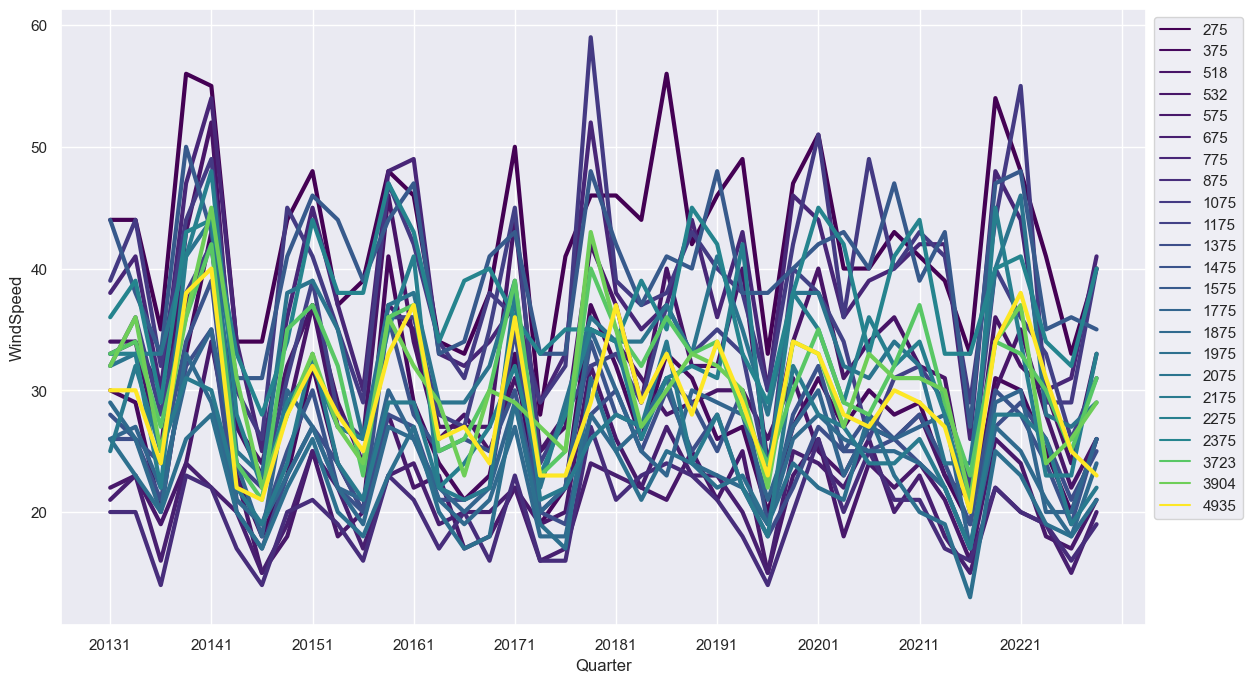

In [87]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=qtrallwddf, x ='QY', y = 'wdsp',
                  hue='station name', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('WindSpeed')
plt.xlabel('Quarter')
plt.show()

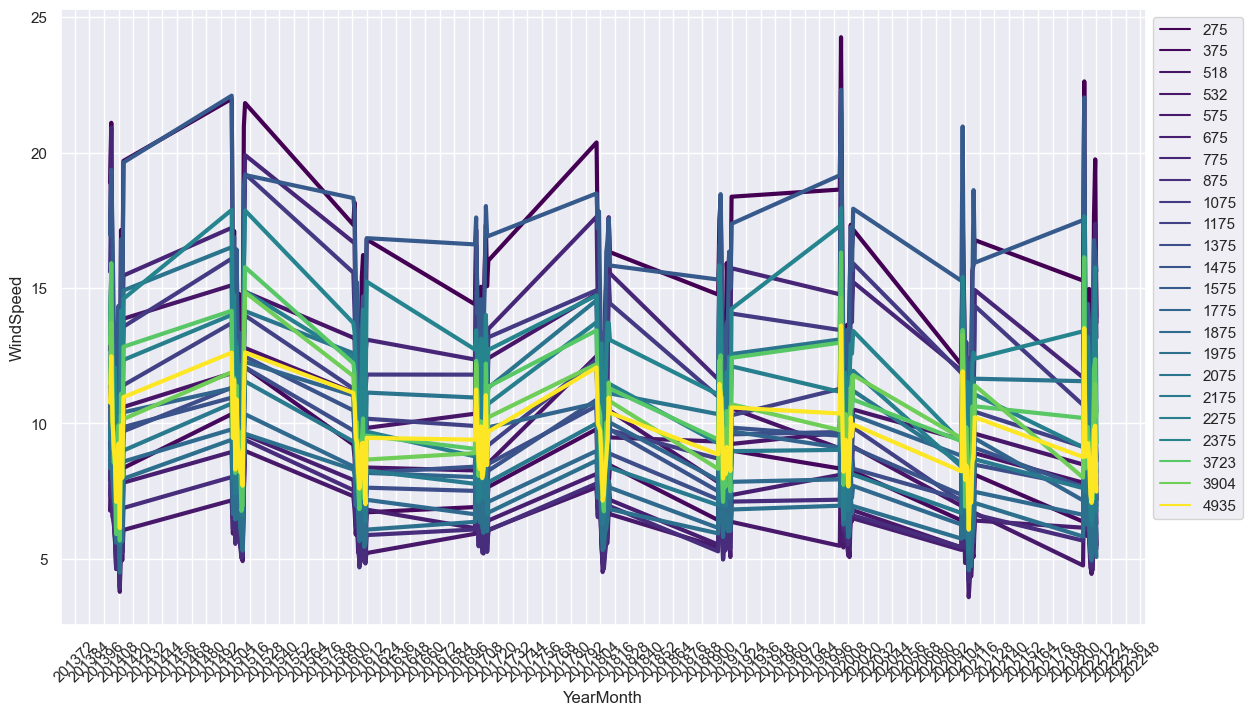

In [67]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=mthallwddf, x ='YM', y = 'wdsp',
                  hue='station name', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax.tick_params(axis='x', rotation=45)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('WindSpeed')
plt.xlabel('YearMonth')
plt.show()

##  No Need to rerun - Download Job  ##
Download WindGeneration data for Ireland(state)
Get the Actual Wind Generation data from https://www.smartgriddashboard.com/DashboardService.svc
Last 3o days data available by using this url.
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ALL&datefrom=04-Feb-2023%2000:00&dateto=05-Mar-2023%2023:59

Crafting urls by manipulating the url parameters allows the possibility of downloading data for custom timeframes.
Attempting to download a full year resulted in an empty file
It was possible to download data in monthly chunks like so
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom=01-Dec-2022%2000:00&dateto=31-Dec-2022%2023:59
Use the calendar and datetime libraries to get the first and last days of each month from 2013 to 2022 and inject these into the url to download the data

In [95]:
import calendar
from datetime import datetime

baseurl="https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom="
separator="%2000:00&dateto="
end="%2023:59"
edfolder="./windgeneration/monthly/"
edfileprefix='WindGenerationROIMonthly'
edfileextension='.csv'

for year in range(2013,2023):
    for month in range(1, 13):
        input_dt = datetime(year, month, 1)
        datefrom=input_dt.strftime('%d-%b-%Y')
        res = calendar.monthrange(input_dt.year, input_dt.month)
        day = res[1]
        last_dt = datetime(year, month, day)
        dateto = last_dt.strftime('%d-%b-%Y')
        monthto=last_dt.strftime('%Y%m')
        url=baseurl+datefrom+separator+dateto+end
        edfile=edfolder+edfileprefix+monthto+edfileextension
        print(url)
        print(edfile)
        if validurl(url):
            response = requests.get(url)
            open(edfile, "wb").write(response.content)

https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom=01-Jan-2013%2000:00&dateto=31-Jan-2013%2023:59
./windgeneration/monthly/WindGenerationROIMonthly201301.csv
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom=01-Feb-2013%2000:00&dateto=28-Feb-2013%2023:59
./windgeneration/monthly/WindGenerationROIMonthly201302.csv
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom=01-Mar-2013%2000:00&dateto=31-Mar-2013%2023:59
./windgeneration/monthly/WindGenerationROIMonthly201303.csv
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom=01-Apr-2013%2000:00&dateto=30-Apr-2013%2023:59
./windgeneration/monthly/WindGenerationROIMonthly201304.csv
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom=01-May-2013%2000:00&dateto=31-May-2013%2023:59
./windgeneration/monthly/WindGenerationROIMon

Plot a sample of the data

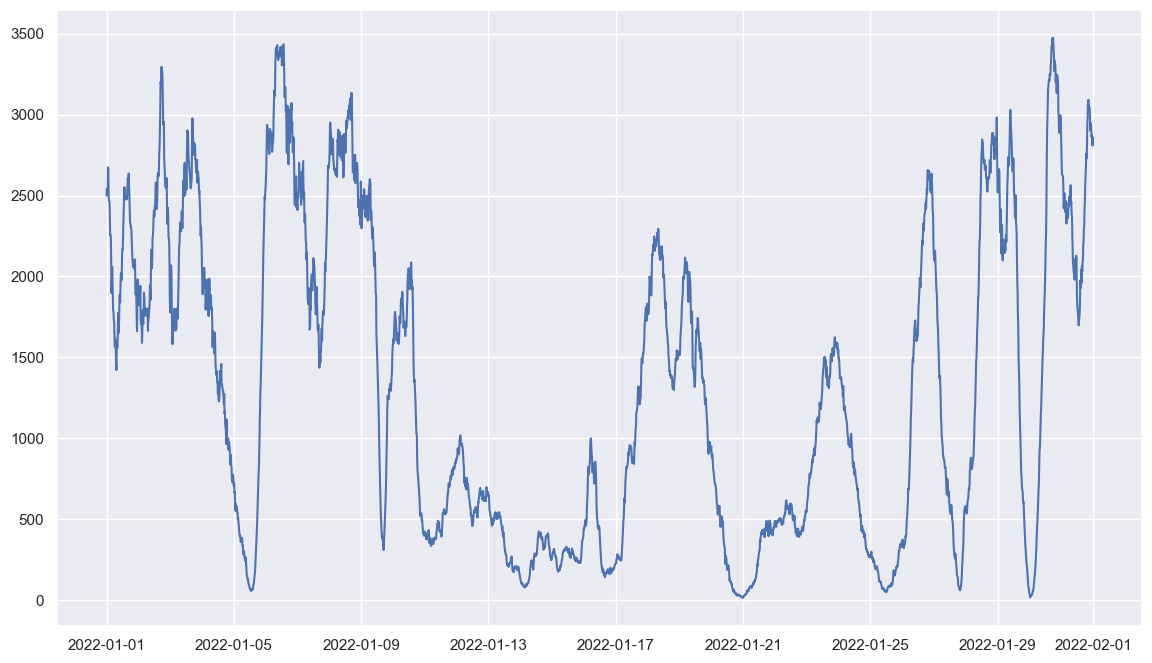

In [88]:
file="./windgeneration/monthly/WindGenerationROIMonthly202201.csv"
wgdf=pd.read_csv(file)

wgdf['datetime'] = pd.to_datetime(wgdf['DATE & TIME'], format='%d %B %Y %H:%M')
columns = list(wgdf.columns.values) 
wgdf.columns = wgdf.columns.str.strip()
wgdf.dtypes
plt.plot(wgdf['datetime'], wgdf['ACTUAL WIND(MW)'])

##  No Need to rerun - Processing Job  ##
Process the files and merge into Single Dataframe

In [114]:
wgalldf=pd.DataFrame()
wgfolder="./windgeneration/monthly/"
wgfileprefix='WindGenerationROIMonthly'
wgfileextension='.csv'
wgprocessedfolder="./windgeneration/processed/"
wgprocessedfile='WindGenerationROIAll.csv'
for file in os.listdir(wgfolder):
    wgfile=wgfolder+file
    wgdf=pd.read_csv(wgfile)
    wgalldf=pd.concat([wgalldf, wgdf], axis=0,ignore_index=True)



In [115]:
wgalldf.dtypes

DATE & TIME           object
 FORECAST WIND(MW)    object
  ACTUAL WIND(MW)     object
 REGION               object
dtype: object

Initial clean of the Data
Remove Whitespace on ACTUAL WIND(MW) columns
Drop duplicate columns
Convert 'DATE & TIME' to datetime and make it the index
We are only interested in the ACTUAL WIND(MW) column, so drop the rest


In [116]:
columns = list(wgalldf.columns.values) 
wgalldf.columns = wgalldf.columns.str.strip()
wgalldf.drop_duplicates(subset=['DATE & TIME', 'ACTUAL WIND(MW)'],inplace = True)
wgalldf['Datetime'] = pd.to_datetime(wgalldf['DATE & TIME'], format='%d %B %Y %H:%M')

wgalldf.reset_index(drop=True) #
wgalldf['Datetime'] = pd.to_datetime(wgalldf['Datetime'])
wgalldf = wgalldf.drop(columns=['DATE & TIME', 'FORECAST WIND(MW)','REGION'])
cols = wgalldf.columns.tolist()
cols = cols[-1:] + cols[:-1]
wgalldf = wgalldf[cols]
wgalldf = wgalldf.set_index(pd.DatetimeIndex(wgalldf['Datetime']))


Attempt to convert 'ACTUAL WIND(MW)' column to int
ValueError: invalid literal for int() with base 10: '-'

In [117]:
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].astype('int')

ValueError: invalid literal for int() with base 10: '-'

Inspect the 'ACTUAL WIND(MW)' column for this character '-'

In [118]:
for k, v in wgalldf[wgalldf['ACTUAL WIND(MW)'] == '-'].groupby((wgalldf['ACTUAL WIND(MW)'] != '-').cumsum()):
    print(f'[group {k}]')
    print(v['Datetime'].min())
    print(v['Datetime'].max())
    print(v.count())
    print('\n')

[group 0]
2013-01-01 00:00:00
2013-05-16 23:45:00
Datetime           13056
ACTUAL WIND(MW)    13056
dtype: int64


[group 480]
2013-05-22 00:00:00
2013-07-18 15:00:00
Datetime           5533
ACTUAL WIND(MW)    5533
dtype: int64


[group 24903]
2014-03-30 01:00:00
2014-03-30 01:45:00
Datetime           4
ACTUAL WIND(MW)    4
dtype: int64


[group 59843]
2015-03-29 01:00:00
2015-03-29 01:45:00
Datetime           4
ACTUAL WIND(MW)    4
dtype: int64


[group 94783]
2016-03-27 01:00:00
2016-03-27 01:45:00
Datetime           4
ACTUAL WIND(MW)    4
dtype: int64


[group 100302]
2016-05-23 13:45:00
2016-05-23 13:45:00
Datetime           1
ACTUAL WIND(MW)    1
dtype: int64


[group 129722]
2017-03-26 01:00:00
2017-03-26 01:45:00
Datetime           4
ACTUAL WIND(MW)    4
dtype: int64


[group 138262]
2017-06-23 01:00:00
2017-06-23 12:15:00
Datetime           46
ACTUAL WIND(MW)    46
dtype: int64


[group 148245]
2017-10-05 12:15:00
2017-10-05 12:15:00
Datetime           1
ACTUAL WIND(MW)    1
dt

Only 5 months of data in 2013, so as it at he start of the dataset dropping 2013 entirely
Also need to remove the 2013 data for windall
Rest of occurences are small, so replacing with '0' 
Replace negative values with positive counterparts, seems to be a data entry error after visual inspection
Resample the data form every 165 minutes to hourly using the mean to match the wind data
Write the datset out to file

In [151]:
pivwddf=pivwddf["2014":"2023"]
wgalldf=wgalldf["2014":"2023"]

#Replace invalid values with '0'
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].replace('-','0')
#Convert 'ACTUAL WIND(MW)' to int
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].astype('int')
#Replace negative values with positive counterparts, seems to be a data entry error after visual inspection
wgalldf['ACTUAL WIND(MW)'] = np.where(wgalldf['ACTUAL WIND(MW)'] < 0,
                                      wgalldf['ACTUAL WIND(MW)'] * -1,
                                      wgalldf['ACTUAL WIND(MW)'])
#Reduce Sample Size from Quarter Hourly to hourly, use the mean for the hour as the new value
wgalldf = wgalldf.resample("H").mean()
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].astype('int')
wgalldf.to_csv('./windgeneration/windgen2014-2022.csv')
wgalldf.head
#[78888 rows x 2 columns]>
#wgalldf.dtypes

<bound method NDFrame.head of                      ACTUAL WIND(MW)
Datetime                            
2014-01-01 00:00:00              976
2014-01-01 01:00:00              914
2014-01-01 02:00:00              938
2014-01-01 03:00:00              911
2014-01-01 04:00:00              915
...                              ...
2022-12-31 19:00:00              358
2022-12-31 20:00:00              545
2022-12-31 21:00:00              522
2022-12-31 22:00:00              511
2022-12-31 23:00:00              537

[78888 rows x 1 columns]>

In [153]:
print(wgalldf.dtypes)
#print(pivwddf.dtypes)

ACTUAL WIND(MW)    int32
dtype: object


Merge the Wind Speed and Windgeneration data

In [154]:
windall = pivwddf.join(wgalldf, how='outer')
#windall.drop('Datetime', axis=1, inplace=True)
windall.dtypes

275                int32
375                int32
518                int32
532                int32
575                int32
675                int32
775                int32
875                int32
1075               int32
1175               int32
1375               int32
1475               int32
1575               int32
1775               int32
1875               int32
1975               int32
2075               int32
2175               int32
2275               int32
2375               int32
3723               int32
3904               int32
4935               int32
ACTUAL WIND(MW)    int32
dtype: object

In [155]:
windall.head

<bound method NDFrame.head of                      275  375  518  532  575  675  775  875  1075  1175  ...  \
Datetime                                                                 ...   
2014-01-01 00:00:00   21    4   10   10    3    9   18    8    15    14  ...   
2014-01-01 01:00:00   21    4   10    9    4    9   19    7    21    13  ...   
2014-01-01 02:00:00   21    5   11    9    4    9   20    7    21     8  ...   
2014-01-01 03:00:00   18    6   11    8    6    8   19    7    20    12  ...   
2014-01-01 04:00:00   19    5   12    8    6   11   19    7    21    13  ...   
...                  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...   
2022-12-31 19:00:00    5    4    4    2    3    3    9    2     5     3  ...   
2022-12-31 20:00:00    5    2    2    2    3    2   18    2    16     2  ...   
2022-12-31 21:00:00    4    6    2    3    5    2   15    2    15     3  ...   
2022-12-31 22:00:00    4    9    2    4    5    2   15    1    15     4  ...   
2022-12-31

Dataset looks good
Write out to file

In [157]:
windall.to_csv('./windgeneration/windall.csv')

In [158]:
cols=windall.columns.values.tolist()
inputparams=cols[:-1]
expected=cols[-1]
print(inputparams)
print(expected)


[275, 375, 518, 532, 575, 675, 775, 875, 1075, 1175, 1375, 1475, 1575, 1775, 1875, 1975, 2075, 2175, 2275, 2375, 3723, 3904, 4935]
ACTUAL WIND(MW)


Modelling the data
Looking at Linear Regression and Random Forest Regression 
## Why???? #
Initially running training on the entire dataset, for the 16th December 00:00 of each year in the dataset 

On this initial test, the RF regression is significantly better than the Linear regression.
Y	    LR	        RF	    Expected
2014	569.3735968	487.65	487
2015	1063.03904	1269.61	1212
2016	582.1128675	671.08	666
2017	361.5460127	479.59	539
2018	1473.804642	1771.49	1847
2019	1183.167491	1246.72	1367
2020	2075.074323	2249.07	2514
2021	863.7137986	937.96	1016
2022	341.9531988	208.44	206

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

cols=windall.columns.values.tolist()
inputparams=cols[:-1]
expected=cols[-1]
print(inputparams)
print(expected)

X = windall[inputparams]
y = windall[expected]

regr = LinearRegression()
regr.fit(X, y)

regrf = RandomForestRegressor()
regrf.fit(X, y)

resdf = pd.DataFrame(columns=['Model', 'Year', 'Expected','Predicted'])

for year in range(2014,2023):
    inputquery="index == '"+str(year)+"-12-16 00:00:00' "
    #print(inputquery)
    inputlist=windall.query(inputquery)[inputparams].values.tolist()
    #print(listy)
    expected=windall.query(inputquery)['ACTUAL WIND(MW)'].values[0]
    #print(expected)
    model='Linear regression'
    predictedWindMW = regr.predict(inputlist)
    print('Model : '+model+", Expected : "+str(expected)+",Predicted Value: "+str(predictedWindMW[0]))
    data = [[model, year,expected,predictedWindMW[0]]]
    resdf = resdf.append(data, ignore_index=True)

    model='Random Forest regression'
    predictedWindMWf = regrf.predict(inputlist)
    print('Model : '+model+", Expected : "+str(expected)+",Predicted Value: "+str(predictedWindMWf[0]))
    data = [[model, year,expected,predictedWindMWf[0]]]
    resdf = resdf.append(data, ignore_index=True)
  
""" # Output the results DataFrame
resdf.to_csv('./modeltests/testresults.csv')

mse = mean_squared_error(sample['ACTUAL WIND(MW)'], preds)
print("The mean squared error (MSE) for Linear Regression on test set: {:.4f}".format(mse))

msef = mean_squared_error(sample['ACTUAL WIND(MW)'], predsf)
print("The mean squared error (MSE) for Forest Regression on test set: {:.4f}".format(msef))

"""

[275, 375, 518, 532, 575, 675, 775, 875, 1075, 1175, 1375, 1475, 1575, 1775, 1875, 1975, 2075, 2175, 2275, 2375, 3723, 3904, 4935]
ACTUAL WIND(MW)
Model : Linear regression, Expected : 487,Predicted Value: 569.3735968239059
Model : Random Forest regression, Expected : 487,Predicted Value: 506.05
Model : Linear regression, Expected : 1212,Predicted Value: 1063.0390403431174
Model : Random Forest regression, Expected : 1212,Predicted Value: 1237.33
Model : Linear regression, Expected : 666,Predicted Value: 582.1128675075347
Model : Random Forest regression, Expected : 666,Predicted Value: 660.81
Model : Linear regression, Expected : 539,Predicted Value: 361.5460126661552
Model : Random Forest regression, Expected : 539,Predicted Value: 488.09
Model : Linear regression, Expected : 1847,Predicted Value: 1473.8046421179165
Model : Random Forest regression, Expected : 1847,Predicted Value: 1828.1
Model : Linear regression, Expected : 1367,Predicted Value: 1183.1674910212787
Model : Random Fo

C:\Users\czl\AppData\Local\Temp\ipykernel_22152\1093384816.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resdf = resdf.append(data, ignore_index=True)
C:\Users\czl\AppData\Local\Temp\ipykernel_22152\1093384816.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resdf = resdf.append(data, ignore_index=True)
C:\Users\czl\AppData\Local\Temp\ipykernel_22152\1093384816.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resdf = resdf.append(data, ignore_index=True)
C:\Users\czl\AppData\Local\Temp\ipykernel_22152\1093384816.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resdf = resdf.append(data, ignore_index=True)
C:\Users\czl

' # Output the results DataFrame\nresdf.to_csv(\'./modeltests/testresults.csv\')\n\nmse = mean_squared_error(sample[\'ACTUAL WIND(MW)\'], preds)\nprint("The mean squared error (MSE) for Linear Regression on test set: {:.4f}".format(mse))\n\nmsef = mean_squared_error(sample[\'ACTUAL WIND(MW)\'], predsf)\nprint("The mean squared error (MSE) for Forest Regression on test set: {:.4f}".format(msef))\n\nr2 = r2_score(sample[\'ACTUAL WIND(MW)\'], preds)\nprint("The Coefficient of determination for all features Linear Regression on test set: {:.4f}".format(r2))\n\nr2f = r2_score(sample[\'ACTUAL WIND(MW)\'], predsf)\nprint("The Coefficient of determination for all features Forest Regression on test set: {:.4f}".format(r2f))\n\nfor feature in inputparams:\n    print(sample[feature])\n    r2 = r2_score(sample[feature], preds)\n    print("The Coefficient of determination for feature: "+str(feature)+" Linear Regression on test set: {:.4f}".format(r2))\n    r2f = r2_score(sample[feature], predsf)\n 

On this initial test, the RF regression is significantly better than the Linear regression.
Y	    LR	        RF	    Expected
2014	569.3735968	487.65	487
2015	1063.03904	1269.61	1212
2016	582.1128675	671.08	666
2017	361.5460127	479.59	539
2018	1473.804642	1771.49	1847
2019	1183.167491	1246.72	1367
2020	2075.074323	2249.07	2514
2021	863.7137986	937.96	1016
2022	341.9531988	208.44	206



To properly evaluate the models, I will run a cross validation. As this is a time series the traditional k-fold cross-validation techniques are not appropriate.
The TimeSeries Split will be used instead with the validation derived from cross_val_score
We have 9 years of training data, so the first 8 can be used for the training and validation and the last year can be used for testing proper.
I am using r2 as the score

C:\Users\czl\AppData\Local\Temp\ipykernel_22152\2606043203.py:11: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_test = windall['2022'].drop([expected], axis = 1)


(70128, 23)
(70128,)
(8760, 23)
(8760,)
LinearRegression: 0.702551 (0.084962)
RandomForestRegressor: 0.756548 (0.073777)


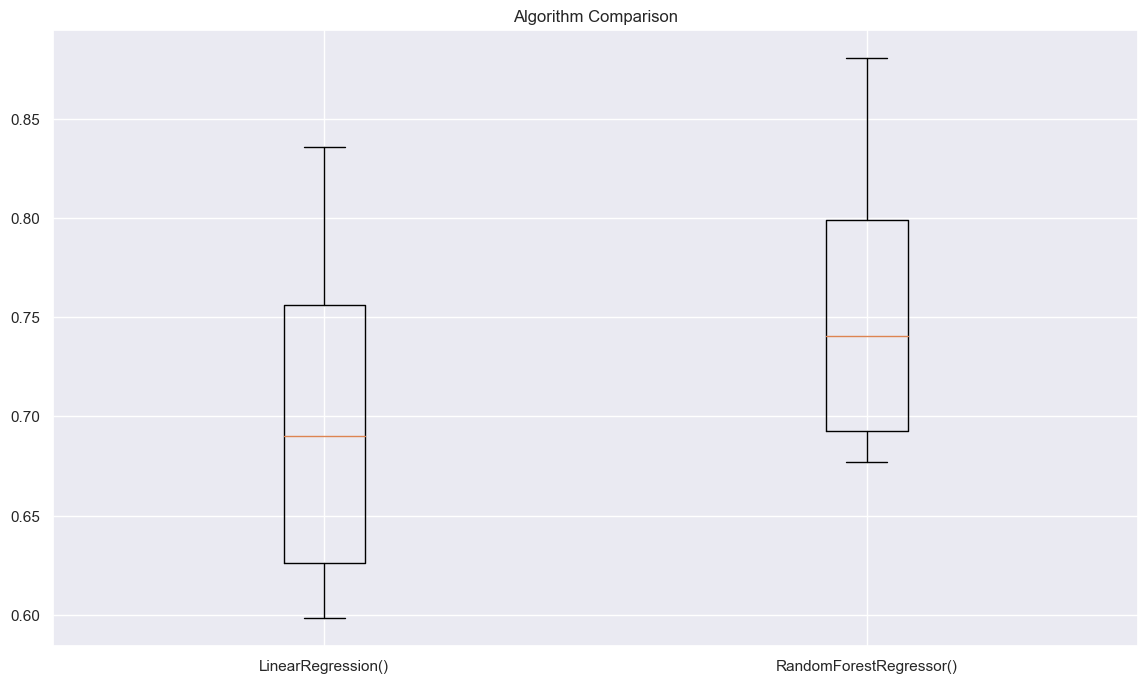

In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

inputparams=cols[:-1]
expected=cols[-1]
X_train = windall[:'2021'].drop([expected], axis = 1)
y_train = windall.loc[:'2021', expected]
X_test = windall['2022'].drop([expected], axis = 1)
y_test = windall.loc['2022', expected]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

models = [LinearRegression(),RandomForestRegressor()]
modelresults = []
for model in models:
   tscrossval = TimeSeriesSplit(n_splits=8)    
   cv_results = cross_val_score(model, X_train, y_train, cv=tscrossval, scoring='r2')
   modelresults.append(cv_results)
   print('%s: %f (%f)' % (str(model)[:-2], cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(modelresults, labels=models)
plt.title('Algorithm Comparison')
plt.show()

LinearRegression: 0.702551 (0.084962)
RandomForestRegressor: 0.756548 (0.073777)
Ran in 4m 47s

RandomForestRegressor is the clear winner

Grid Search to get the best hyperparameter configuration
n_estimators : integer, optional (default=10)

    The number of trees in the forest.

max_features : int, float, string or None, optional (default=”auto”)

    The number of features to consider when looking for the best split:

        If int, then consider max_features features at each split.
        If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
        If “auto”, then max_features=n_features.
        If “sqrt”, then max_features=sqrt(n_features).
        If “log2”, then max_features=log2(n_features).
        If None, then max_features=n_features.

    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features. Note: this parameter is tree-specific.

max_depth : integer or None, optional (default=None)

    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Ignored if max_leaf_nodes is not None. Note: this parameter is tree-specific.

n_jobs : integer, optional (default=1)

    The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.


In [171]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_jobs': [-1,1],
    'n_estimators': [10, 20, 50],
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=8)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [172]:
print("The best hyperparameters found during the grid search are:")
print(best_model)
print(best_score)

The best hyperparameters found during the grid search are:
RandomForestRegressor(max_depth=14, n_estimators=50, n_jobs=1)
0.7529136783787332


Using the test data, test the model with the best_model hyperparameters

In [173]:

y_pred = best_model.predict(X_test)

r2f = r2_score(y_test.values, y_pred)
print(r2f)


0.7438093479962249


Analyse the best features

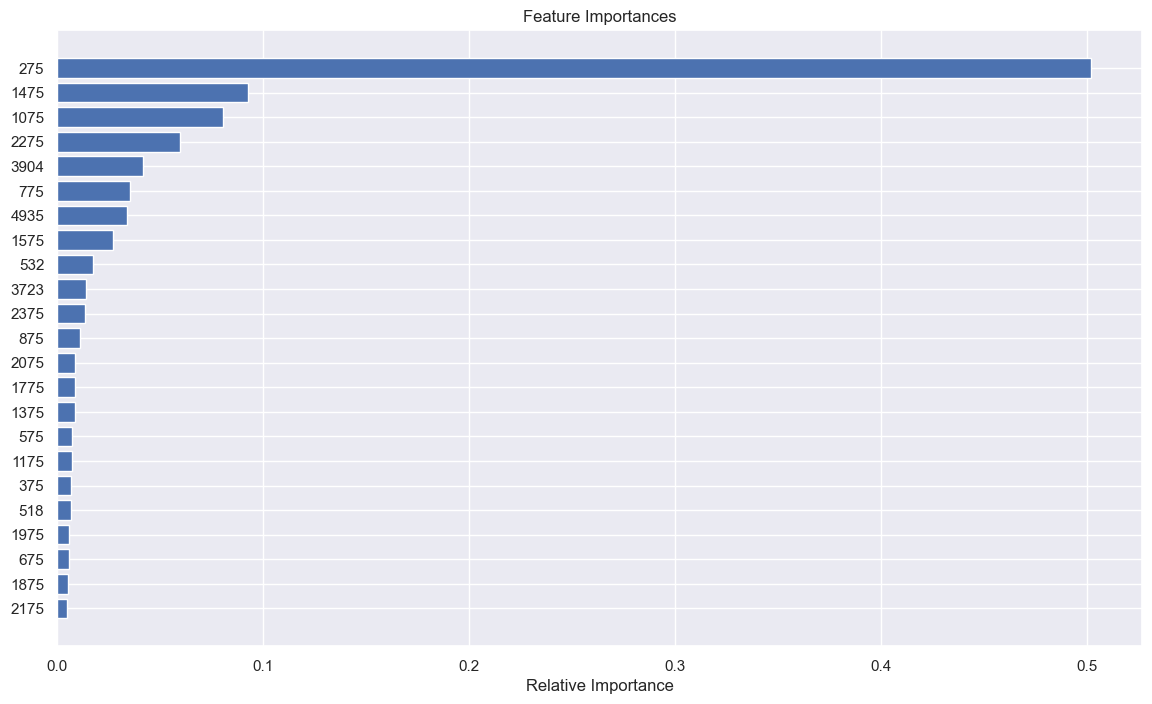

In [174]:
importance = best_model.feature_importances_
features = X_test.columns
indices = np.argsort(importance)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Rerunning the model with the best hyperparameters suggested and geting an r2f of 0.98

In [230]:
regrf = RandomForestRegressor(max_depth=14, n_estimators=50, n_jobs=1)
regrf.fit(X_test, y_test)
y_pred=regrf.predict(X_test)
r2f = r2_score(y_test.values, y_pred)
print(r2f)



0.9859820556402982


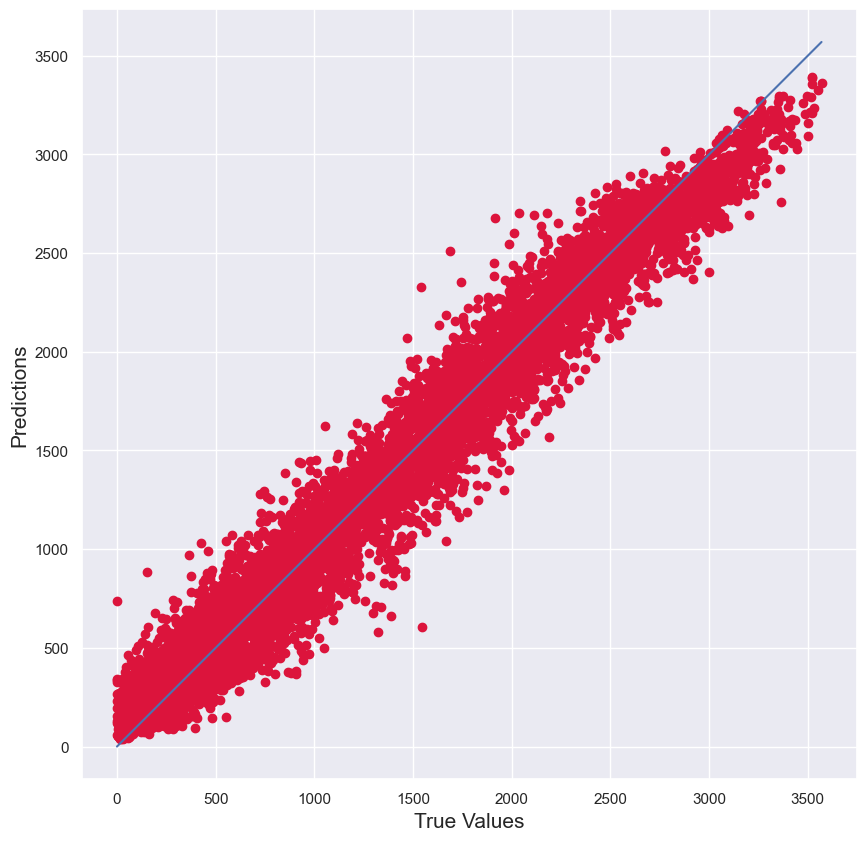

In [233]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.values, y_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_test.values))
p2 = min(min(y_pred), min(y_test.values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Make a copy of the test data, drop all but the top5 features and rerun the model and geting an r2f of 0.97

In [243]:
X_test2=X_test[[275]]

regrf = RandomForestRegressor(max_depth=14, n_estimators=50, n_jobs=1)
regrf.fit(X_test2, y_test)
y_pred=regrf.predict(X_test2)
r2f = r2_score(y_test.values, y_pred)
print(r2f)

0.7313609238822036


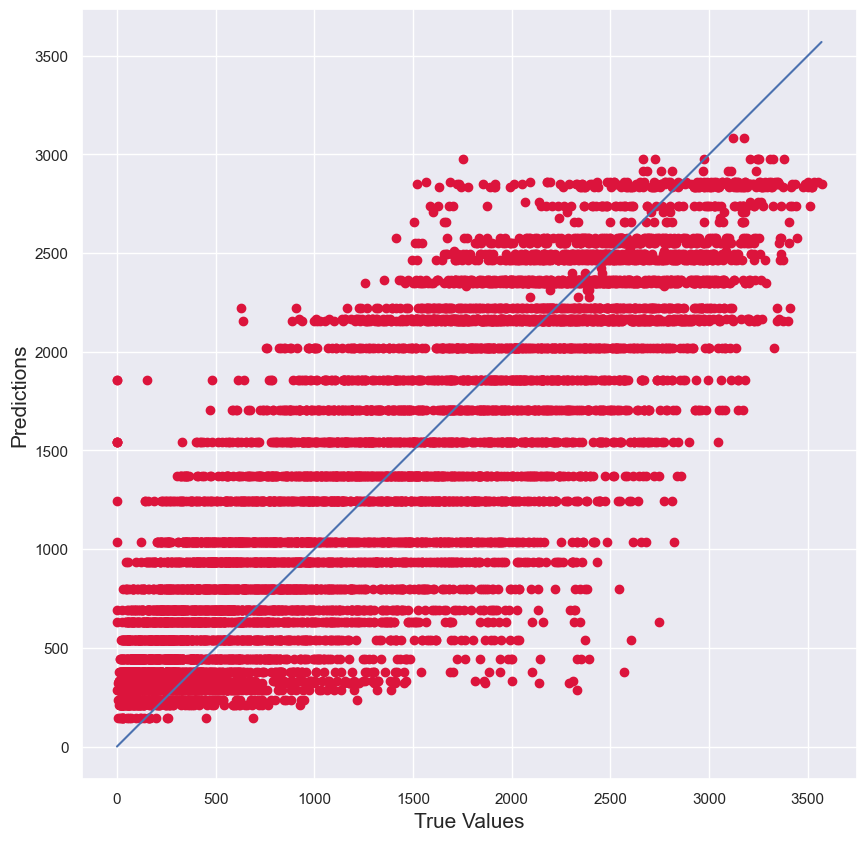

In [244]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.values, y_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_test.values))
p2 = min(min(y_pred), min(y_test.values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [242]:
cols=windall.columns.values.tolist()
inputparams=cols[:-1]
#expected=cols[-1]
#print(inputparams)
#print(expected)

X = X_test   #[inputparams]
y = y_test   #[expected]
print(X)
print(y)

regrf = RandomForestRegressor(max_depth=14, n_estimators=50, n_jobs=1)
regrf.fit(X, y)

resdf = pd.DataFrame(columns=['Model', 'Year', 'Expected','Predicted'])

for month in range(1,13):
    monthstr=str(month).zfill(2)
    inputquery="index == '2022-"+monthstr+"-16 00:00:00' "
    #print(inputquery)
    inputlist=X.query(inputquery).values.tolist()
    print(inputlist)
    expected=y[0].query(inputquery)  #.query(inputquery)
    #print(expected)
    model='Random Forest regression'
    predictedWindMWf = regrf.predict(inputlist)
    print('Model : '+model+", Expected : "+str(expected)+",Predicted Value: "+str(predictedWindMWf[0]))
    data = [[model, year,expected,predictedWindMWf[0]]]
    resdf = resdf.append(data, ignore_index=True) 
    break

                     275   375   518   532   575   675   775   875   1075  \
Datetime                                                                    
2022-01-01 00:00:00    22    16    21    18    13    14    28    16    28   
2022-01-01 01:00:00    23    18    16    21    16    16    30    16    30   
2022-01-01 02:00:00    25    15    18    21    19    14    32    16    28   
2022-01-01 03:00:00    27    23    27    15    18    15    32    15    30   
2022-01-01 04:00:00    25    24    29    12    18    12    33    16    34   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-12-31 19:00:00     5     4     4     2     3     3     9     2     5   
2022-12-31 20:00:00     5     2     2     2     3     2    18     2    16   
2022-12-31 21:00:00     4     6     2     3     5     2    15     2    15   
2022-12-31 22:00:00     4     9     2     4     5     2    15     1    15   
2022-12-31 23:00:00     4    12     2     4     4     2    14     1    10   

AttributeError: 'numpy.int32' object has no attribute 'query'